<a href="https://colab.research.google.com/github/vamshigitt/-Backtesting-a-strategy-using-ML.-/blob/main/Backtesting_strategy_using_ML1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [548]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [372]:
from google.colab import files
uploaded=files.upload()

Saving Timeseries OHLC.csv to Timeseries OHLC (3).csv


In [373]:
ohlc=pd.read_csv("Timeseries OHLC.csv")
ohlc.head(1)

,OPEN,HIGH,LOW,CLOSE,OPEN_LAG1,HIGH_LAG1,LOW_LAG1,CLOSE_LAG1,OPEN_LAG2,HIGH_LAG2,...,DAYOFMONTH,DAYOFWEEK,DAYOFYEAR,MONTH,DIFF_LAG1_OPEN,DIFF_LAG1_HIGH,DIFF_LAG1_LOW,DIFF_LAG1_CLOSE,TARGET_CLOSE,TARGET_OPEN
0,1.18025,1.1905,1.1792,1.18641,1.17617,1.18063,1.17213,1.18027,1.17708,1.17967,...,5.0,3.0,217.0,8.0,0.00408,0.00987,0.00707,0.00614,1.18768,1.18627


In [374]:
ohlc.columns

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'OPEN_LAG1', 'HIGH_LAG1', 'LOW_LAG1',
       'CLOSE_LAG1', 'OPEN_LAG2', 'HIGH_LAG2', 'LOW_LAG2', 'CLOSE_LAG2',
       'OPEN_LAG3', 'HIGH_LAG3', 'LOW_LAG3', 'CLOSE_LAG3', '30DAY_SMA',
       '7DAY_STDDEV', 'DAYOFMONTH', 'DAYOFWEEK', 'DAYOFYEAR', 'MONTH',
       'DIFF_LAG1_OPEN', 'DIFF_LAG1_HIGH', 'DIFF_LAG1_LOW', 'DIFF_LAG1_CLOSE',
       'TARGET_CLOSE', 'TARGET_OPEN'],
      dtype='object')

In [375]:
ohlc.shape

(1000, 28)

In [376]:
ohlc.isnull().sum()

,0
OPEN,0
HIGH,0
LOW,0
CLOSE,0
OPEN_LAG1,0
HIGH_LAG1,0
LOW_LAG1,0
CLOSE_LAG1,0
OPEN_LAG2,0
HIGH_LAG2,0


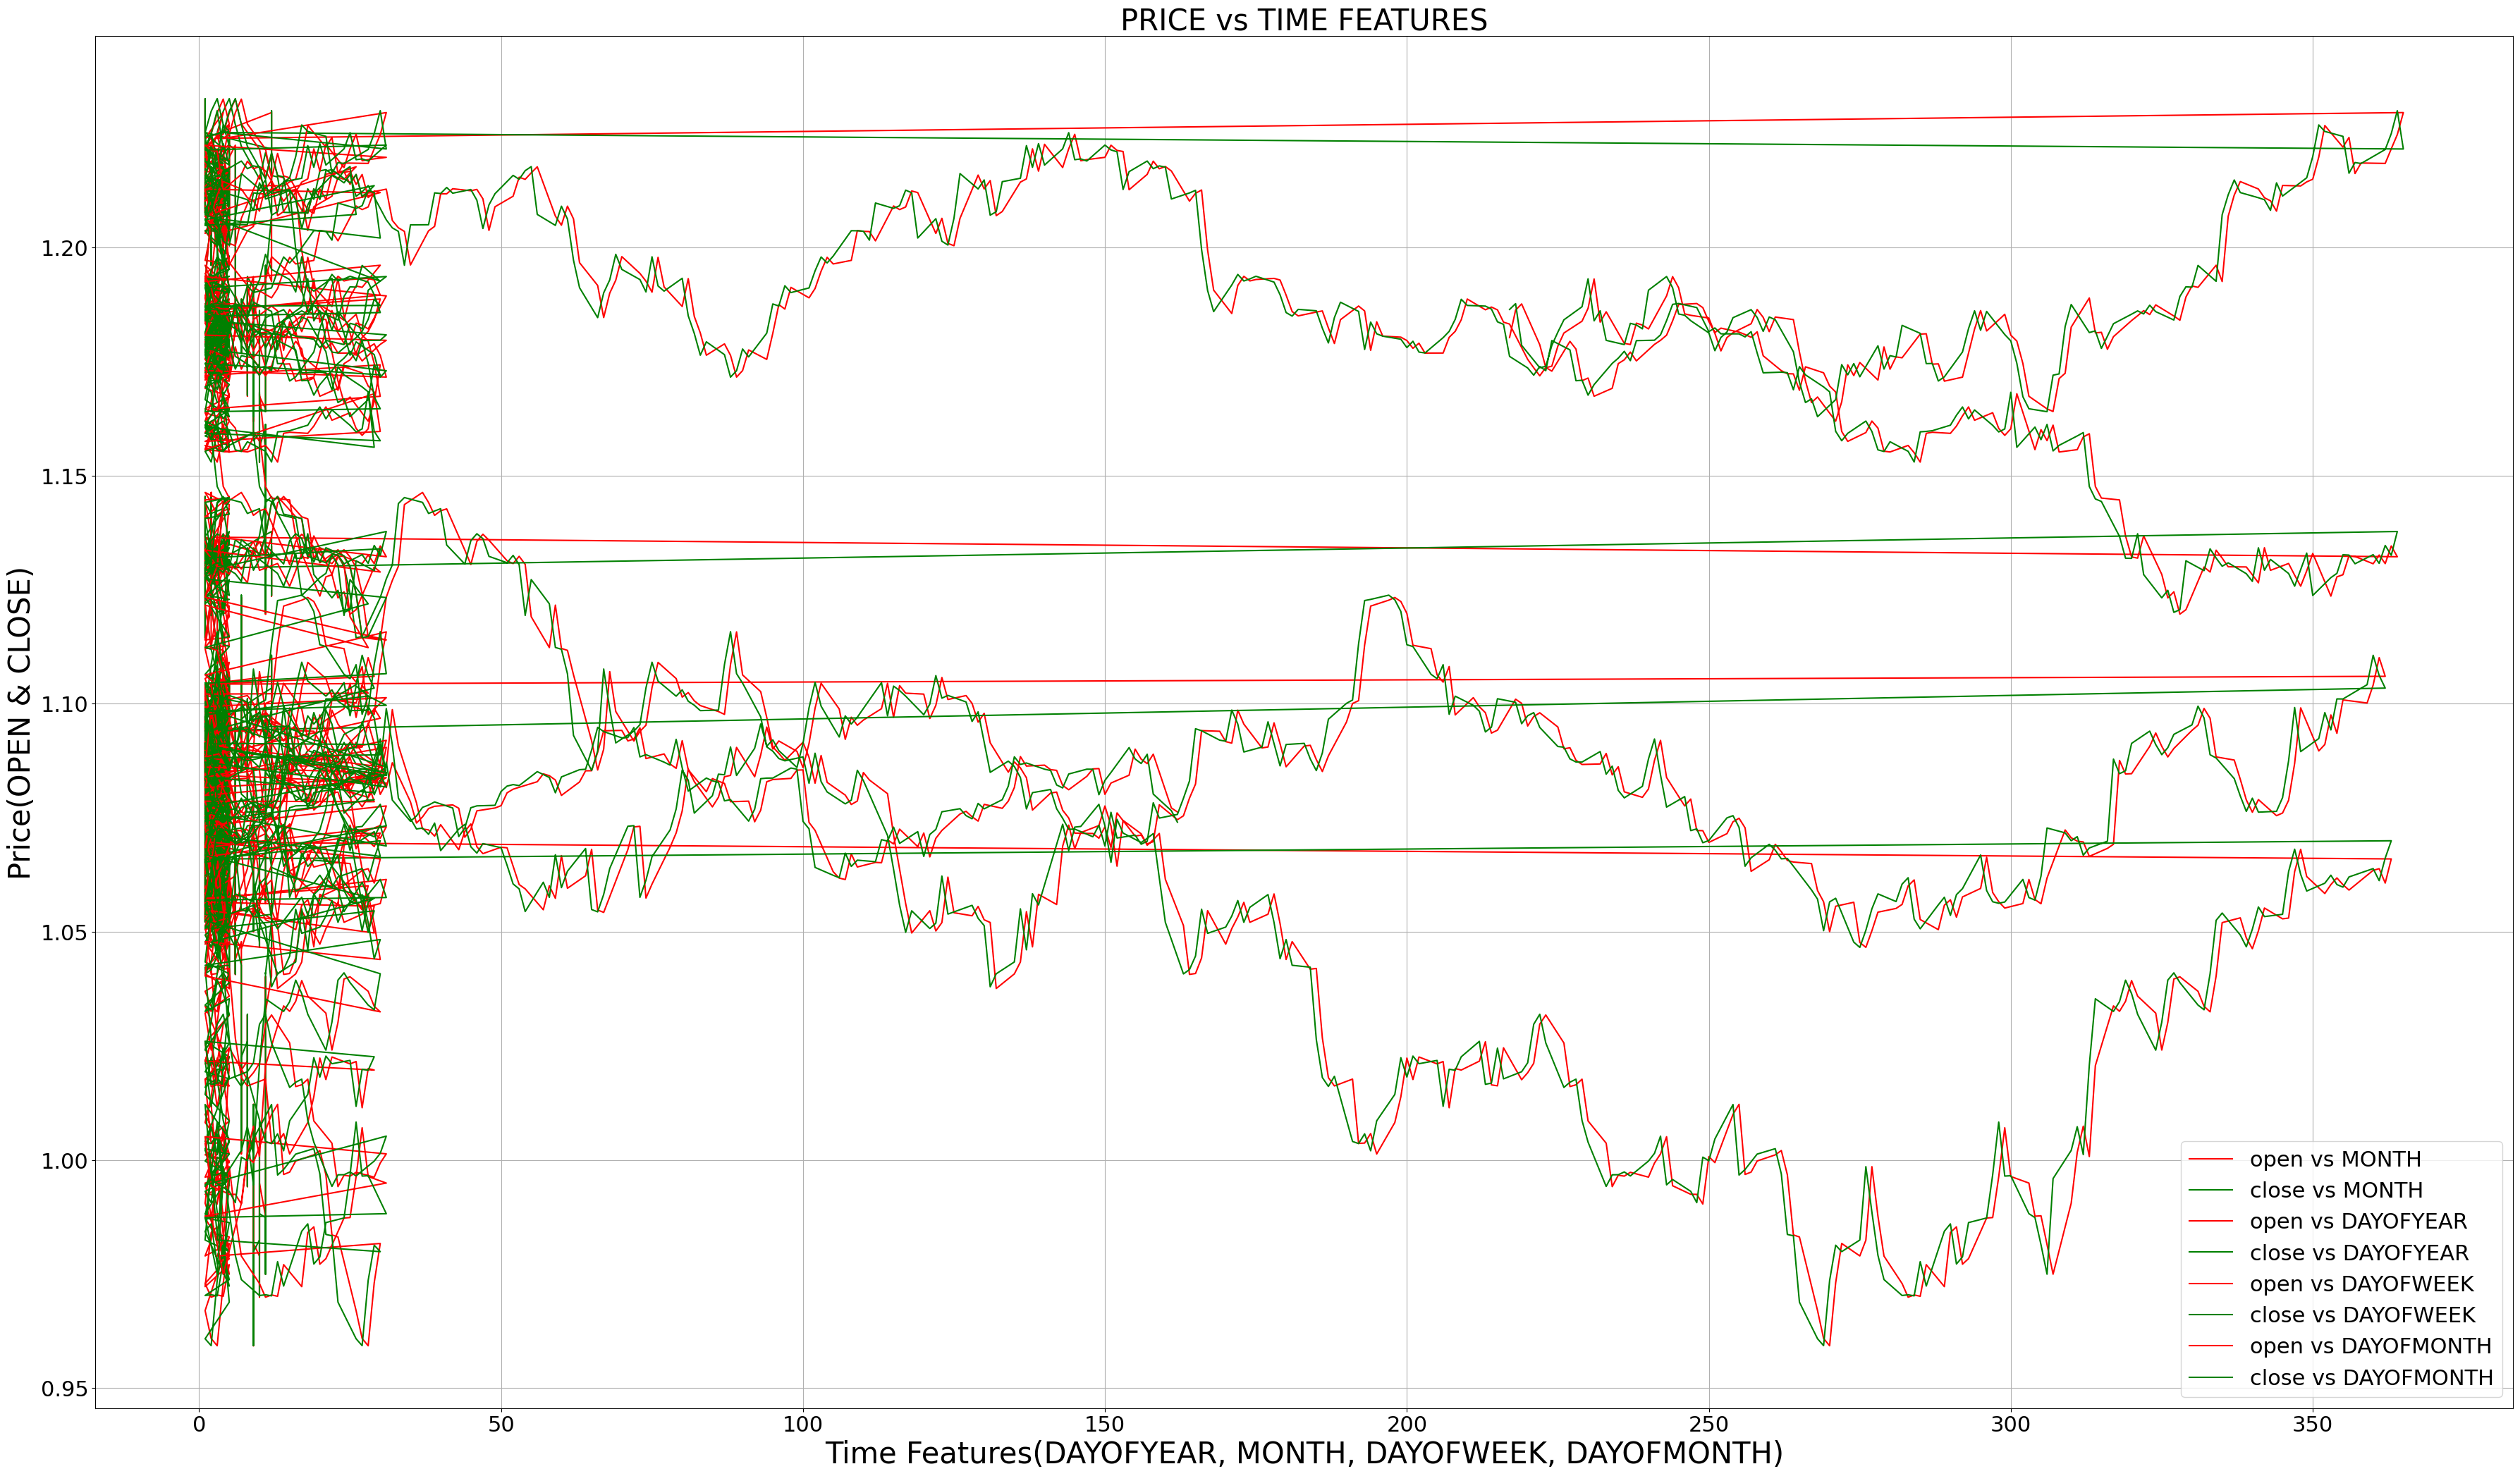

In [377]:
#Timeseries plot
Time_features = ['MONTH', 'DAYOFYEAR','DAYOFWEEK', 'DAYOFMONTH']
plt.figure(figsize=(35, 20))

for feature in Time_features:
    plt.plot(ohlc[feature], ohlc['OPEN'], label='open vs '+ str(feature), color='red')
    plt.plot(ohlc[feature], ohlc['CLOSE'], label='close vs '+ str(feature), color='green')

plt.grid(True)
plt.tight_layout()
plt.title('PRICE vs TIME FEATURES', fontsize=30)
plt.xlabel('Time Features(DAYOFYEAR, MONTH, DAYOFWEEK, DAYOFMONTH)', fontsize=30)
plt.ylabel('Price(OPEN & CLOSE)', fontsize=30)
plt.legend(fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [378]:
#New year column

#row counts
rows_2000 = 106
rows_2001 = 260
rows_2002 = 259
rows_2003 = 259
rows_2004 = 116

#creating year for each row
year_2000 = np.full(rows_2000, 2000)
year_2001 = np.full(rows_2001, 2001)
year_2002 = np.full(rows_2002, 2002)
year_2003 = np.full(rows_2003, 2003)
year_2004 = np.full(rows_2004, 2004)

#Concatenating
ohlc['YEAR'] = np.concatenate([
    year_2000,
    year_2001,
    year_2002,
    year_2003,
    year_2004
])

print('year column created')
ohlc.tail()
ohlc.iloc[106]

year column created


,106
OPEN,1.223910
HIGH,1.230950
LOW,1.222750
CLOSE,1.225200
OPEN_LAG1,1.229560
HIGH_LAG1,1.230940
LOW_LAG1,1.220920
CLOSE_LAG1,1.221580
OPEN_LAG2,1.224730
HIGH_LAG2,1.231010


In [379]:
ohlc.sample(8)

,OPEN,HIGH,LOW,CLOSE,OPEN_LAG1,HIGH_LAG1,LOW_LAG1,CLOSE_LAG1,OPEN_LAG2,HIGH_LAG2,...,DAYOFWEEK,DAYOFYEAR,MONTH,DIFF_LAG1_OPEN,DIFF_LAG1_HIGH,DIFF_LAG1_LOW,DIFF_LAG1_CLOSE,TARGET_CLOSE,TARGET_OPEN,YEAR
609,1.05022,1.05650,1.04896,1.05546,1.04631,1.05498,1.04432,1.05058,1.04866,1.05330,...,4.0,341.0,12.0,0.00391,0.00152,0.00464,0.00488,1.05335,1.05523,2002
563,0.99854,0.99950,0.98350,0.98858,0.98243,0.99997,0.98063,0.99855,0.97898,0.98445,...,3.0,277.0,10.0,0.01611,-0.00047,0.00287,-0.00997,0.97911,0.98769,2002
182,1.20372,1.20798,1.20225,1.20365,1.19717,1.20479,1.19426,1.20367,1.19639,1.19946,...,2.0,109.0,4.0,0.00655,0.00319,0.00799,-0.00002,1.20356,1.20353,2001
64,1.16405,1.17398,1.16231,1.17201,1.16463,1.16558,1.16222,1.16401,1.16738,1.17043,...,2.0,307.0,11.0,-0.00058,0.00840,0.00009,0.00800,1.17229,1.17127,2000
442,1.07792,1.08144,1.07611,1.07887,1.07998,1.08217,1.07699,1.07806,1.08277,1.08299,...,2.0,108.0,4.0,-0.00206,-0.00073,-0.00088,0.00081,1.08542,1.07868,2002
496,1.04183,1.04627,1.04160,1.04226,1.04787,1.04833,1.03657,1.04268,1.04395,1.04887,...,1.0,184.0,7.0,-0.00604,-0.00206,0.00503,-0.00042,1.02640,1.04199,2002
866,1.08344,1.08475,1.07782,1.07978,1.08766,1.08951,1.08040,1.08359,1.08835,1.09129,...,2.0,338.0,12.0,-0.00422,-0.00476,-0.00258,-0.00381,1.07640,1.07892,2003
652,1.07236,1.07608,1.07095,1.07139,1.07255,1.07667,1.06691,1.07275,1.07828,1.07989,...,3.0,38.0,2.0,-0.00019,-0.00059,0.00404,-0.00136,1.07385,1.07099,2003


In [380]:
ohlc['YEAR'].value_counts().sort_index()

,count
YEAR,
2000,106
2001,260
2002,259
2003,259
2004,116


In [381]:
ohlc.iloc[100:110]

,OPEN,HIGH,LOW,CLOSE,OPEN_LAG1,HIGH_LAG1,LOW_LAG1,CLOSE_LAG1,OPEN_LAG2,HIGH_LAG2,...,DAYOFWEEK,DAYOFYEAR,MONTH,DIFF_LAG1_OPEN,DIFF_LAG1_HIGH,DIFF_LAG1_LOW,DIFF_LAG1_CLOSE,TARGET_CLOSE,TARGET_OPEN,YEAR
100,1.21620,1.22211,1.21539,1.21861,1.22411,1.22573,1.21523,1.21627,1.22199,1.22531,...,3.0,357.0,12.0,-0.00791,-0.00362,0.00016,0.00234,1.21840,1.21851,2000
101,1.21851,1.22156,1.21772,1.21840,1.21620,1.22211,1.21539,1.21861,1.22411,1.22573,...,4.0,358.0,12.0,0.00231,-0.00055,0.00233,-0.00021,1.22147,1.21842,2000
102,1.21842,1.22505,1.21810,1.22147,1.21851,1.22156,1.21772,1.21840,1.21620,1.22211,...,1.0,362.0,12.0,-0.00009,0.00349,0.00038,0.00307,1.22495,1.22162,2000
103,1.22162,1.22751,1.22068,1.22495,1.21842,1.22505,1.21810,1.22147,1.21851,1.22156,...,2.0,363.0,12.0,0.00320,0.00246,0.00258,0.00348,1.22998,1.22473,2000
104,1.22473,1.23101,1.22460,1.22998,1.22162,1.22751,1.22068,1.22495,1.21842,1.22505,...,3.0,364.0,12.0,0.00311,0.00350,0.00392,0.00503,1.22158,1.22956,2000
105,1.22956,1.23094,1.22092,1.22158,1.22473,1.23101,1.22460,1.22998,1.22162,1.22751,...,4.0,365.0,12.0,0.00483,-0.00007,-0.00368,-0.00840,1.22520,1.22391,2000
106,1.22391,1.23095,1.22275,1.22520,1.22956,1.23094,1.22092,1.22158,1.22473,1.23101,...,1.0,3.0,1.0,-0.00565,0.00001,0.00183,0.00362,1.22984,1.22483,2001
107,1.22483,1.23057,1.22432,1.22984,1.22391,1.23095,1.22275,1.22520,1.22956,1.23094,...,2.0,4.0,1.0,0.00092,-0.00038,0.00157,0.00464,1.23262,1.22953,2001
108,1.22953,1.23495,1.22656,1.23262,1.22483,1.23057,1.22432,1.22984,1.22391,1.23095,...,3.0,5.0,1.0,0.00470,0.00438,0.00224,0.00278,1.22693,1.23251,2001
109,1.23251,1.23445,1.22451,1.22693,1.22953,1.23495,1.22656,1.23262,1.22483,1.23057,...,4.0,6.0,1.0,0.00298,-0.00050,-0.00205,-0.00569,1.22218,1.22707,2001


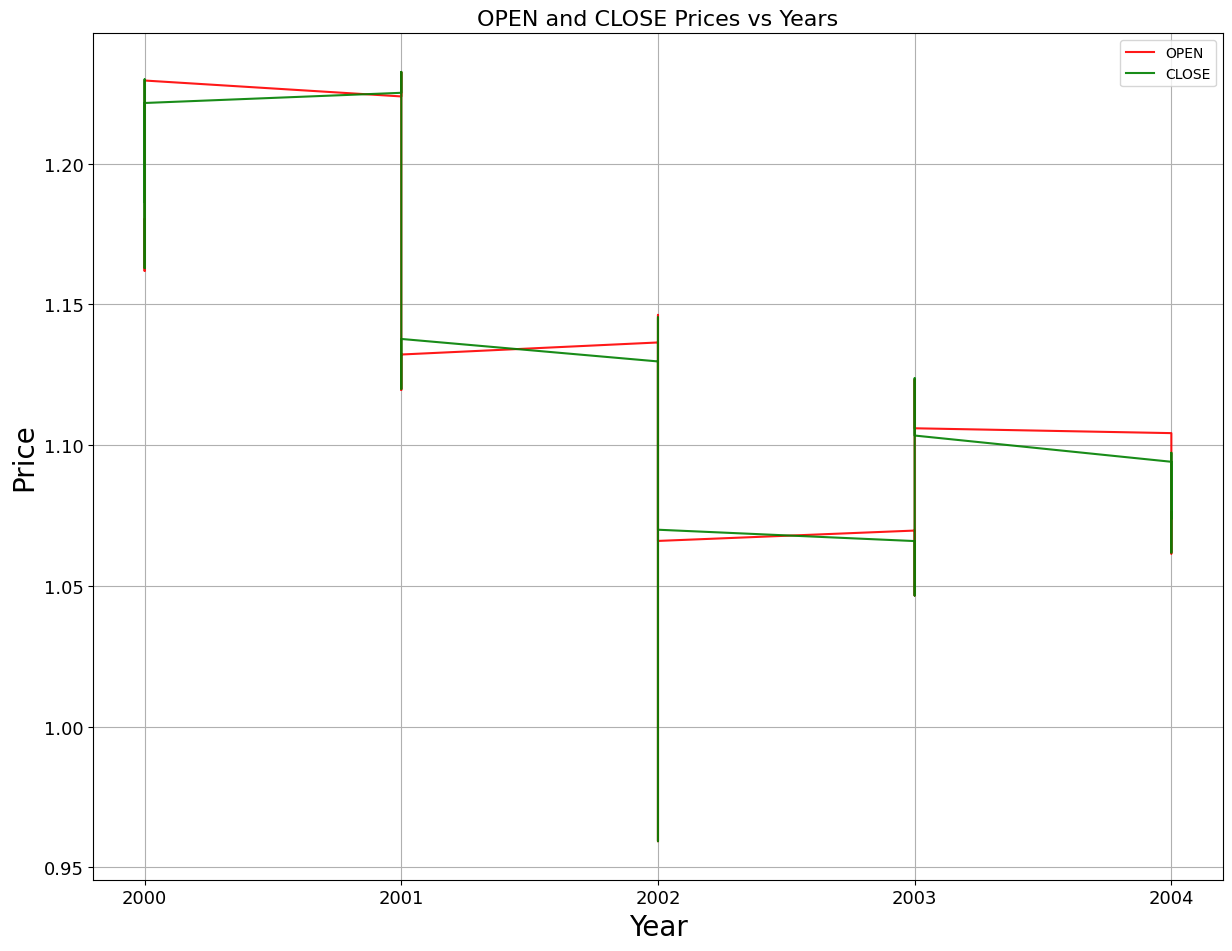

In [382]:
#timeseries plot  (PRICE vs YEAR)
plt.figure(figsize=[12,9])

plt.plot(ohlc['YEAR'], ohlc['OPEN'], label='OPEN', color='red', alpha=0.9)
plt.plot(ohlc['YEAR'], ohlc['CLOSE'], label='CLOSE', color='green', alpha=0.9)


plt.grid(True)
plt.tight_layout()
plt.title('OPEN and CLOSE Prices vs Years', fontsize=16)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.xticks(ohlc['YEAR'].unique(), fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
plt.show()


In [383]:
#New date column

ohlc['MONTH'] = ohlc['MONTH'].astype(int)
ohlc['DAYOFMONTH'] = ohlc['DAYOFMONTH'].astype(int)
ohlc['YEAR'] = ohlc['YEAR'].astype(int)

date_components = ohlc[['YEAR', 'MONTH', 'DAYOFMONTH']].copy()
date_components = date_components.rename(columns={'YEAR': 'year', 'MONTH': 'month', 'DAYOFMONTH': 'day'})

ohlc['DATE'] = pd.to_datetime(date_components)

print('date column created')
ohlc.head(20)


date column created


,OPEN,HIGH,LOW,CLOSE,OPEN_LAG1,HIGH_LAG1,LOW_LAG1,CLOSE_LAG1,OPEN_LAG2,HIGH_LAG2,...,DAYOFYEAR,MONTH,DIFF_LAG1_OPEN,DIFF_LAG1_HIGH,DIFF_LAG1_LOW,DIFF_LAG1_CLOSE,TARGET_CLOSE,TARGET_OPEN,YEAR,DATE
0,1.18025,1.19050,1.17920,1.18641,1.17617,1.18063,1.17213,1.18027,1.17708,1.17967,...,217.0,8,0.00408,0.00987,0.00707,0.00614,1.18768,1.18627,2000,2000-08-05
1,1.18627,1.19162,1.18179,1.18768,1.18025,1.19050,1.17920,1.18641,1.17617,1.18063,...,218.0,8,0.00602,0.00112,0.00259,0.00127,1.17855,1.18762,2000,2000-08-06
2,1.18762,1.18831,1.17553,1.17855,1.18627,1.19162,1.18179,1.18768,1.18025,1.19050,...,219.0,8,0.00135,-0.00331,-0.00626,-0.00913,1.17365,1.17869,2000,2000-08-07
3,1.17869,1.18007,1.17360,1.17365,1.18762,1.18831,1.17553,1.17855,1.18627,1.19162,...,222.0,8,-0.00893,-0.00824,-0.00193,-0.00490,1.17394,1.17365,2000,2000-08-10
4,1.17365,1.18080,1.17220,1.17394,1.17869,1.18007,1.17360,1.17365,1.18762,1.18831,...,223.0,8,-0.00504,0.00073,-0.00140,0.00029,1.17853,1.17398,2000,2000-08-11
5,1.17398,1.18171,1.17111,1.17853,1.17365,1.18080,1.17220,1.17394,1.17869,1.18007,...,224.0,8,0.00033,0.00091,-0.00109,0.00459,1.18145,1.17839,2000,2000-08-12
6,1.17839,1.18642,1.17776,1.18145,1.17398,1.18171,1.17111,1.17853,1.17365,1.18080,...,225.0,8,0.00441,0.00471,0.00665,0.00292,1.18414,1.18125,2000,2000-08-13
7,1.18125,1.18504,1.17817,1.18414,1.17839,1.18642,1.17776,1.18145,1.17398,1.18171,...,226.0,8,0.00286,-0.00138,0.00041,0.00269,1.18701,1.18384,2000,2000-08-14
8,1.18384,1.18810,1.18281,1.18701,1.18125,1.18504,1.17817,1.18414,1.17839,1.18642,...,229.0,8,0.00259,0.00306,0.00464,0.00287,1.19313,1.18666,2000,2000-08-17
9,1.18666,1.19657,1.18611,1.19313,1.18384,1.18810,1.18281,1.18701,1.18125,1.18504,...,230.0,8,0.00282,0.00847,0.00330,0.00612,1.18392,1.19310,2000,2000-08-18


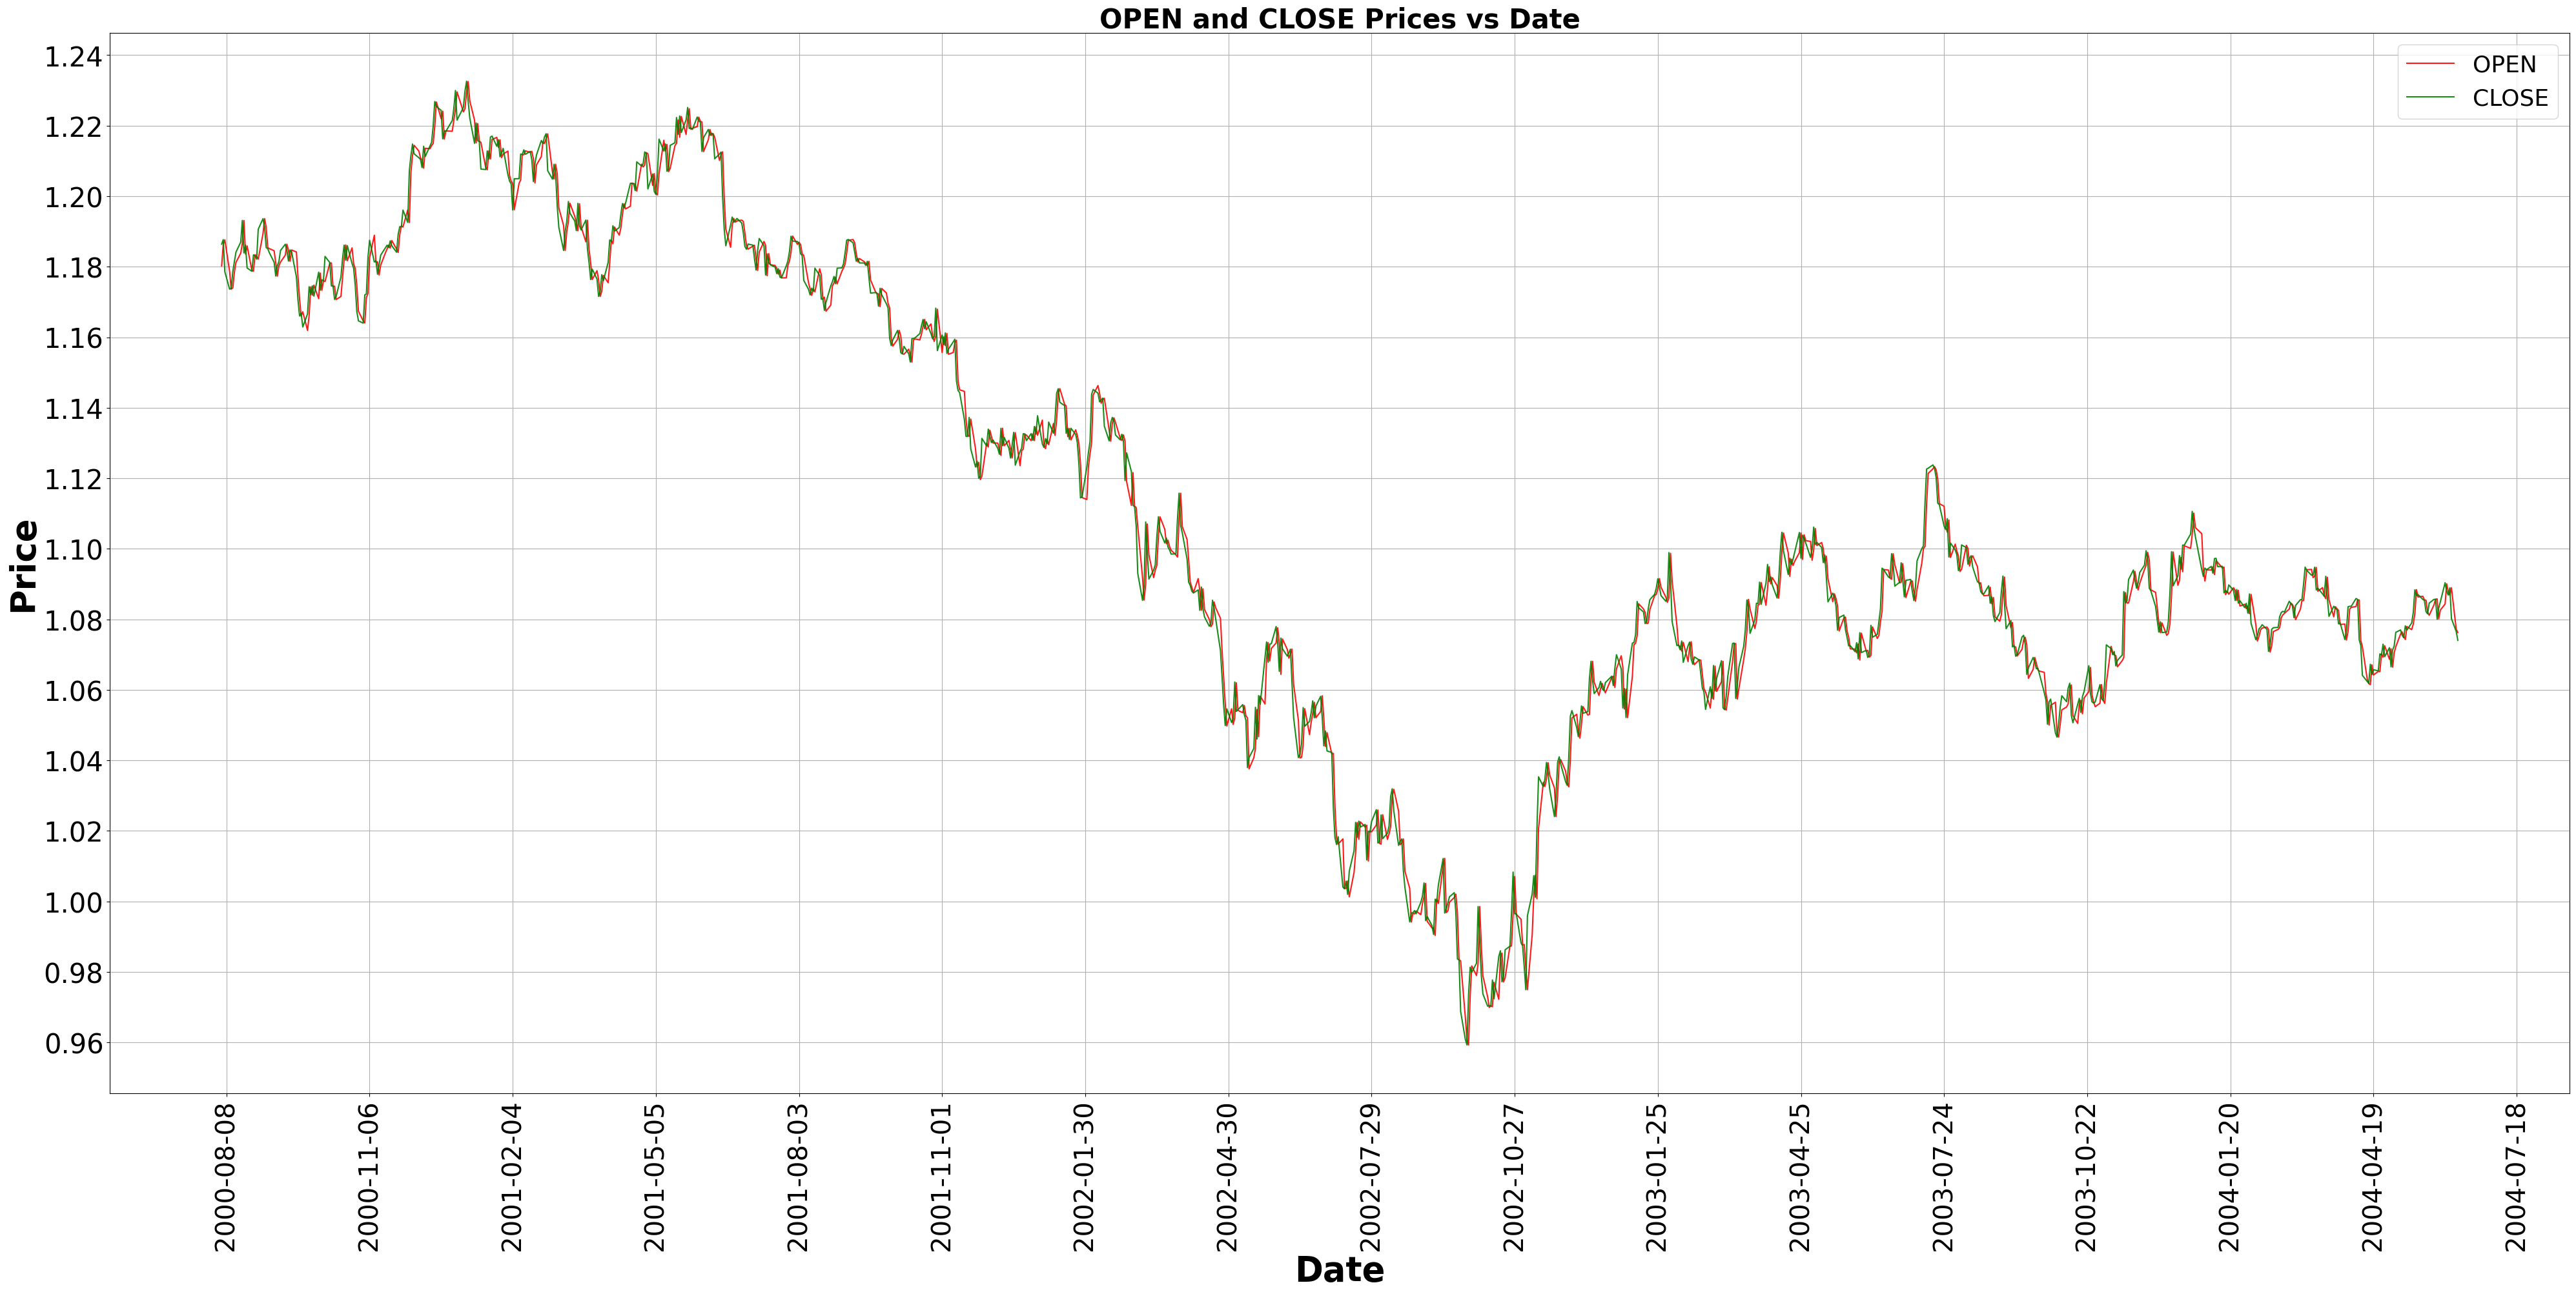

In [384]:
#final Timeseries plot (price vs Date)

plt.figure(figsize=(40,19.5))

plt.plot(ohlc['DATE'], ohlc['OPEN'],label='OPEN', color='red', alpha=0.9)
plt.plot(ohlc['DATE'], ohlc['CLOSE'],label='CLOSE', color='green', alpha=0.9)


plt.title('OPEN and CLOSE Prices vs Date', fontsize=30, fontweight='bold')
plt.xlabel('Date', fontsize=38, fontweight='bold')
plt.ylabel('Price', fontsize=38, fontweight='bold')
plt.xticks(fontsize=29, rotation=90)
plt.yticks(fontsize=30)
plt.grid()
plt.tight_layout()
plt.legend(fontsize=26)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=90))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=20))

plt.show()

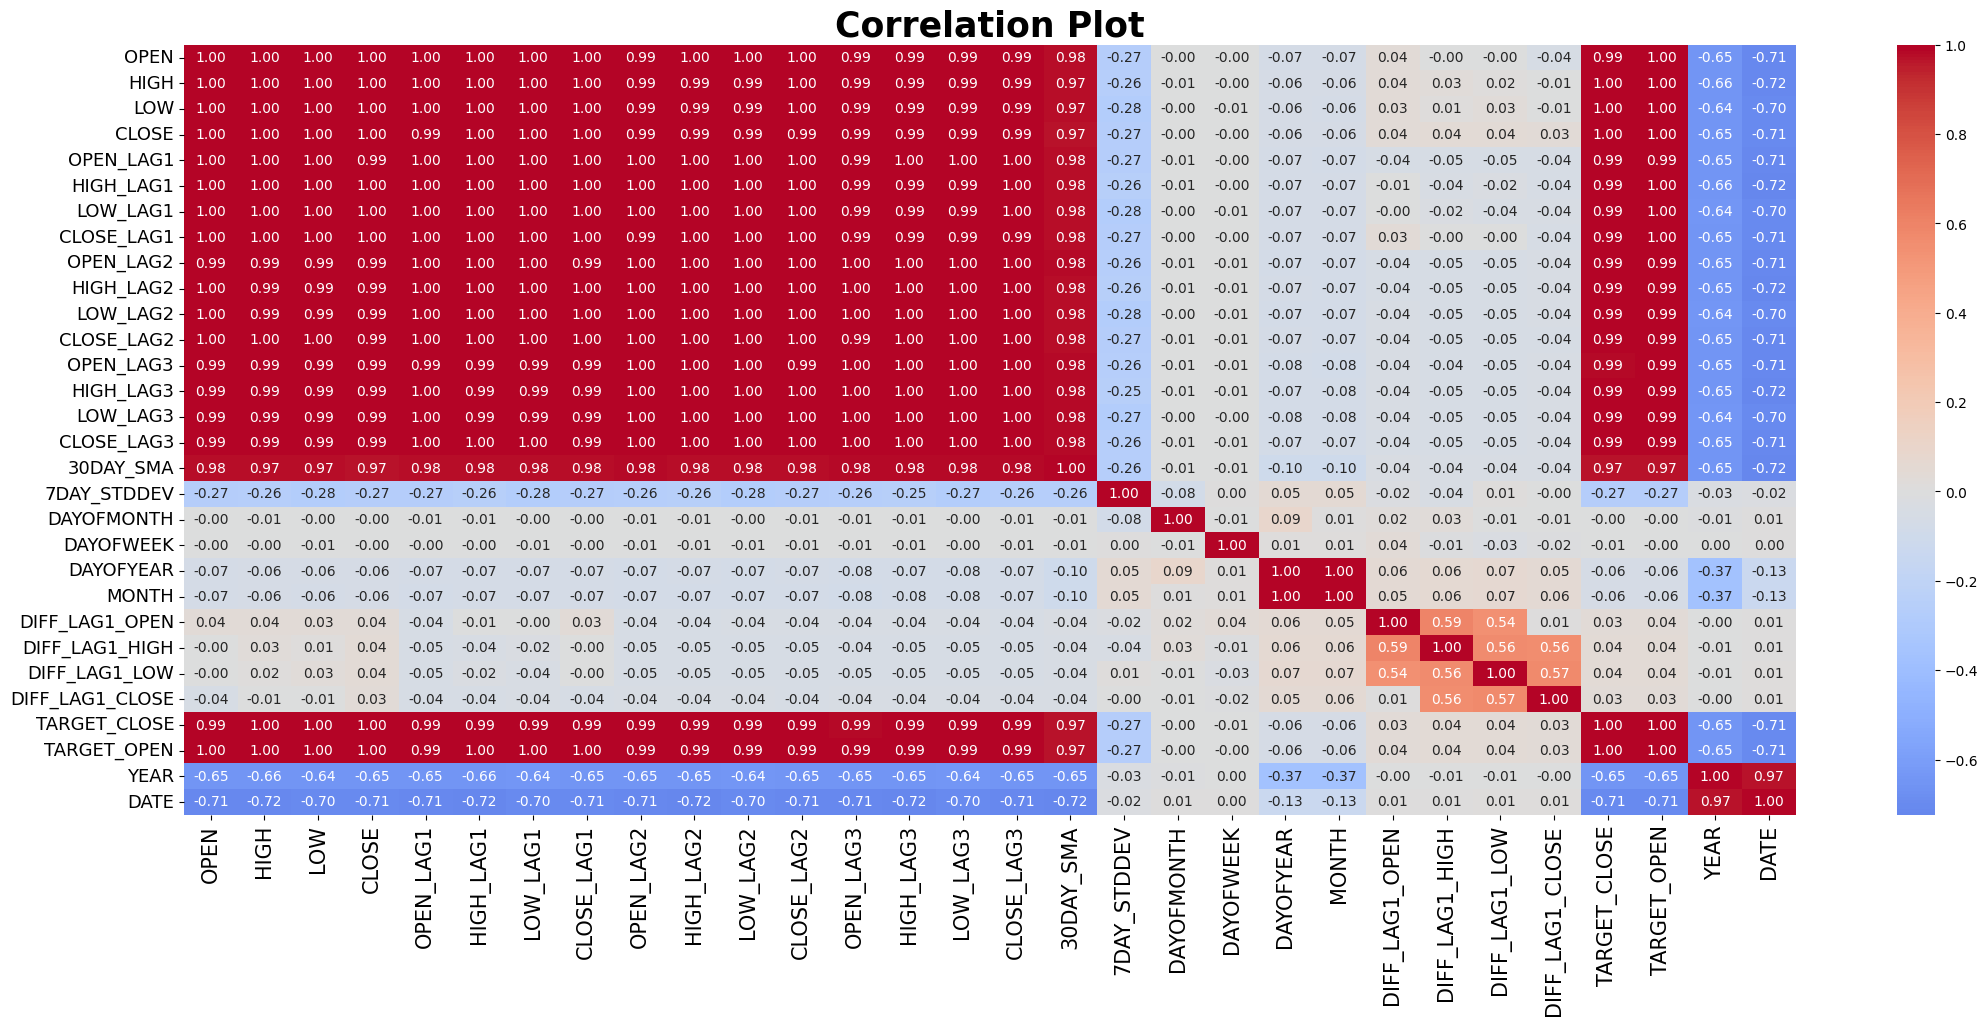

In [385]:
#Correlation plot
corr = ohlc.corr()
plt.figure(figsize=(26, 10))
sns.heatmap(corr, cmap='coolwarm' , center=0, annot=True, fmt=".2f")
plt.title('Correlation Plot', fontsize=25, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.show()

In [386]:
# Add percentage change features
ohlc['RET_CLOSE'] = ohlc['CLOSE'].pct_change()
ohlc['RET_OPEN'] = ohlc['OPEN'].pct_change()
ohlc['RET_OPEN'].head()

,RET_OPEN
0,NaN
1,0.005101
2,0.001138
3,-0.007519
4,-0.004276


In [387]:
# Rolling volatility and mean
ohlc['ROLL_MEAN_5'] = ohlc['CLOSE'].rolling(5).mean()
ohlc['ROLL_STD_5'] = ohlc['CLOSE'].rolling(5).std()
#ohlc['ROLL_MEAN_5'].head()
#ohlc['ROLL_STD_5'].head()

In [388]:
# Drop NaN rows created by rolling/pct_change
ohlc.dropna(inplace=True)
ohlc.shape

(996, 34)

In [389]:
#Creating a new Target column(target variable= Next price direction): 1 if price goes up, 0 if price goes down
ohlc['TARGET'] = (ohlc['TARGET_CLOSE'] > ohlc['CLOSE']).astype(int)
ohlc['TARGET'].head(7)


,TARGET
4,1
5,1
6,1
7,1
8,1
9,0
10,1


In [390]:
ohlc.columns

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'OPEN_LAG1', 'HIGH_LAG1', 'LOW_LAG1',
       'CLOSE_LAG1', 'OPEN_LAG2', 'HIGH_LAG2', 'LOW_LAG2', 'CLOSE_LAG2',
       'OPEN_LAG3', 'HIGH_LAG3', 'LOW_LAG3', 'CLOSE_LAG3', '30DAY_SMA',
       '7DAY_STDDEV', 'DAYOFMONTH', 'DAYOFWEEK', 'DAYOFYEAR', 'MONTH',
       'DIFF_LAG1_OPEN', 'DIFF_LAG1_HIGH', 'DIFF_LAG1_LOW', 'DIFF_LAG1_CLOSE',
       'TARGET_CLOSE', 'TARGET_OPEN', 'YEAR', 'DATE', 'RET_CLOSE', 'RET_OPEN',
       'ROLL_MEAN_5', 'ROLL_STD_5', 'TARGET'],
      dtype='object')

In [391]:
ohlc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 4 to 999
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OPEN             996 non-null    float64       
 1   HIGH             996 non-null    float64       
 2   LOW              996 non-null    float64       
 3   CLOSE            996 non-null    float64       
 4   OPEN_LAG1        996 non-null    float64       
 5   HIGH_LAG1        996 non-null    float64       
 6   LOW_LAG1         996 non-null    float64       
 7   CLOSE_LAG1       996 non-null    float64       
 8   OPEN_LAG2        996 non-null    float64       
 9   HIGH_LAG2        996 non-null    float64       
 10  LOW_LAG2         996 non-null    float64       
 11  CLOSE_LAG2       996 non-null    float64       
 12  OPEN_LAG3        996 non-null    float64       
 13  HIGH_LAG3        996 non-null    float64       
 14  LOW_LAG3         996 non-null    float64       

In [392]:
#Preparing data for modeling
X = ohlc.drop(['TARGET', 'TARGET_CLOSE', 'TARGET_OPEN','DATE'],axis=1)
Y = ohlc['TARGET']

In [393]:
# Remove highly correlated features (>0.95)
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [c for c in upper_tri.columns if any(upper_tri[c] > 0.95)]
X = X.drop(columns=to_drop)

In [394]:
X.head().T

,4,5,6,7,8
OPEN,1.173650,1.173980,1.178390,1.181250,1.183840
7DAY_STDDEV,0.004651,0.004442,0.004431,0.004054,0.003818
DAYOFMONTH,11.000000,12.000000,13.000000,14.000000,17.000000
DAYOFWEEK,2.000000,3.000000,4.000000,5.000000,1.000000
DAYOFYEAR,223.000000,224.000000,225.000000,226.000000,229.000000
DIFF_LAG1_OPEN,-0.005040,0.000330,0.004410,0.002860,0.002590
DIFF_LAG1_HIGH,0.000730,0.000910,0.004710,-0.001380,0.003060
DIFF_LAG1_LOW,-0.001400,-0.001090,0.006650,0.000410,0.004640
DIFF_LAG1_CLOSE,0.000290,0.004590,0.002920,0.002690,0.002870
YEAR,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000


In [501]:
#Splitting data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=40,shuffle=False)

print("Training set shape:", X_train.shape, Y_train.shape)
print("Testing set shape:", X_test.shape, Y_test.shape)

Training set shape: (796, 11) (796,)
Testing set shape: (200, 11) (200,)


In [502]:
#scaling the feature
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**1.Logistic Regression Model**

In [503]:
#Initializing
lr_model = LogisticRegression(random_state=40,max_iter=1000)

#Fitting
lr_model.fit(X_train_scaled, Y_train)

#Predicting
Y_pred = lr_model.predict(X_test_scaled)
print("working")

working


In [504]:
accuracy = accuracy_score(Y_test, Y_pred)

print(f"Accuracy Score: {accuracy:.4f}")

Accuracy Score: 0.4900


In [505]:
correct_predictions = (Y_pred == Y_test).sum()
incorrect_predictions = (Y_pred != Y_test).sum()
print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")

Correct Predictions: 98
Incorrect Predictions: 102


In [508]:
class_report = classification_report(Y_test, Y_pred)
print("Classification Report:\n\n", class_report)

Classification Report:

               precision    recall  f1-score   support

           0       0.48      0.94      0.64        96
           1       0.57      0.08      0.14       104

    accuracy                           0.49       200
   macro avg       0.53      0.51      0.39       200
weighted avg       0.53      0.49      0.38       200



In [509]:
#cross-validation
cv_scores = cross_val_score(lr_model, X, Y, cv=5)

print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

Cross-validation scores: [0.505      0.44723618 0.3919598  0.51256281 0.44221106]
Mean cross-validation accuracy: 0.4598


In [510]:
#defining the parameters
param_grid = {
    'penalty': ['l1','l2','elasticnet','none'],
    'C': [0.001,0.01,0.1,0.5],
    'solver': ['liblinear','saga','lbfgs'],
    'max_iter': [100,500,1000]
}

lr = LogisticRegression(random_state=40)

grid_search = GridSearchCV(estimator=lr,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train_scaled, Y_train)
print('fitted')


Fitting 5 folds for each of 144 candidates, totalling 720 fits
fitted


In [511]:
print("best parameters: " + str(grid_search.best_params_))

best parameters: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}


In [512]:
#hyperparameter tuning

Tuned_lr_model = LogisticRegression(C=0.001, max_iter=100, penalty='l2', solver='saga')

Tuned_lr_model.fit(X_train_scaled, Y_train)

Y_pred_tuned =Tuned_lr_model.predict(X_test_scaled)

Tuned_accuracy = accuracy_score(Y_test, Y_pred_tuned)
Tuned_Classification_Report = classification_report(Y_test, Y_pred_tuned)


print("Accuracy Score: " + str(Tuned_accuracy))
print("\nClassification Report:\n " + str(Tuned_Classification_Report))

Accuracy Score: 0.485

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.89      0.62        96
           1       0.52      0.12      0.19       104

    accuracy                           0.48       200
   macro avg       0.50      0.50      0.41       200
weighted avg       0.50      0.48      0.40       200



In [513]:
Y_pred_proba_tuned = Tuned_lr_model.predict_proba(X_test_scaled)[:, 1]

#roc-auc score
roc_auc_tuned = roc_auc_score(Y_test, Y_pred_proba_tuned)

print(f"Tuned Model ROC AUC Score: {roc_auc_tuned:.4f}")

Tuned Model ROC AUC Score: 0.5045


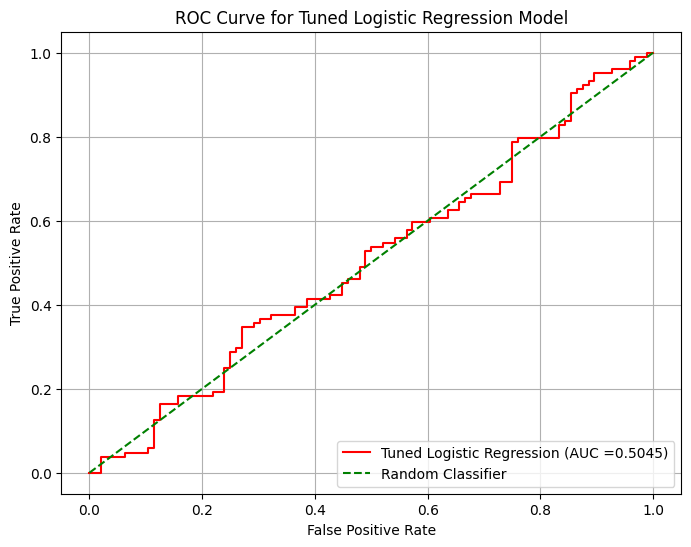

In [514]:
#ROC curve values
fpr, tpr,_= roc_curve(Y_test, Y_pred_proba_tuned)

#ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Tuned Logistic Regression (AUC ={roc_auc_tuned:.4f})', color='red')
plt.plot([0, 1], [0, 1], '--', label='Random Classifier', color='green')
plt.title('ROC Curve for Tuned Logistic Regression Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

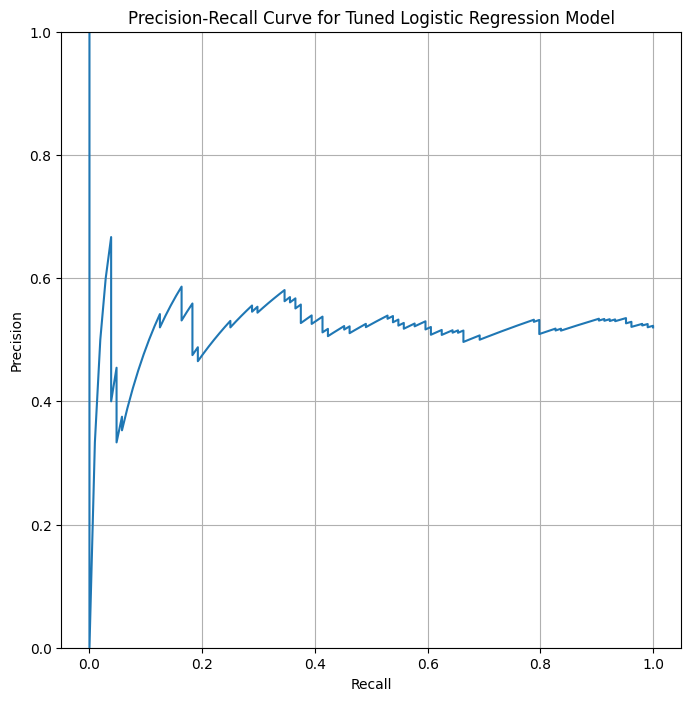

In [515]:
#precision-recall curve
precision, recall, _ = precision_recall_curve(Y_test, Y_pred_proba_tuned)

#average precision score
plt.figure(figsize=(8, 8))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Tuned Logistic Regression Model')
plt.grid()
plt.ylim(0, 1)
plt.show()

[[85 11]
 [92 12]]


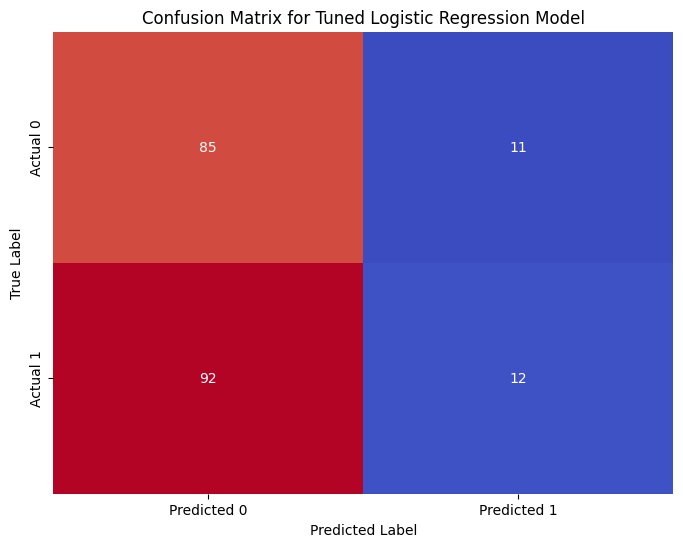

In [516]:
#confusion matrix
cm=confusion_matrix(Y_test, Y_pred_tuned)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Tuned Logistic Regression Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**2.Random Forest Model**

In [519]:
#Initializing
rf_model = RandomForestClassifier(random_state=40)

#Fitting
rf_model.fit(X_train_scaled, Y_train)

#predicting
Y_pred_rf = rf_model.predict(X_test_scaled)
print("working")

working


In [520]:
rf_accuracy = accuracy_score(Y_test, Y_pred_rf)

print(f"Accuracy Score: {rf_accuracy:.4f}")

Accuracy Score: 0.5300


In [521]:
correct_predictions = (Y_pred_rf == Y_test).sum()
incorrect_predictions = (Y_pred_rf != Y_test).sum()
print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")

Correct Predictions: 106
Incorrect Predictions: 94


In [522]:
class_report = classification_report(Y_test, Y_pred_rf)
print("Classification Report:\n\n", class_report)

Classification Report:

               precision    recall  f1-score   support

           0       0.51      0.56      0.53        96
           1       0.55      0.50      0.53       104

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200



In [523]:
#cross-validation
cv_scores = cross_val_score(rf_model, X, Y, cv=5)

print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

Cross-validation scores: [0.495      0.48743719 0.3919598  0.45728643 0.52763819]
Mean cross-validation accuracy: 0.4719


In [524]:
#defining the parameters
param_grid = {
  'n_estimators': [100, 200, 300],
  'max_depth': [None, 10, 20]

}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train_scaled, Y_train)
print('fitted')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
fitted


In [525]:
print("best parameters: " + str(grid_search.best_params_)) #300

best parameters: {'max_depth': 10, 'n_estimators': 100}


In [526]:
#hyperparameter tuning
tuned_rf=RandomForestClassifier(max_depth= 10, n_estimators= 100, random_state=40)
tuned_rf.fit(X_train_scaled, Y_train)

Y_pred_tuned_rf = tuned_rf.predict(X_test_scaled)
tuned_rf_accuracy = accuracy_score(Y_test, Y_pred_tuned_rf)
tuned_classification_report = classification_report(Y_test, Y_pred_tuned_rf)

print(f"Accuracy Score: {tuned_rf_accuracy:.4f}")
print("\nClassification Report:\n " + str(tuned_classification_report))

Accuracy Score: 0.5300

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.51      0.51        96
           1       0.55      0.55      0.55       104

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200



In [527]:
Y_pred_proba_tuned_rf = tuned_rf.predict_proba(X_test_scaled)[:, 1]

#roc-auc score
roc_auc_tuned_rf = roc_auc_score(Y_test, Y_pred_proba_tuned_rf)

print(f"Tuned Model ROC AUC Score: {roc_auc_tuned_rf:.4f}")

Tuned Model ROC AUC Score: 0.5724


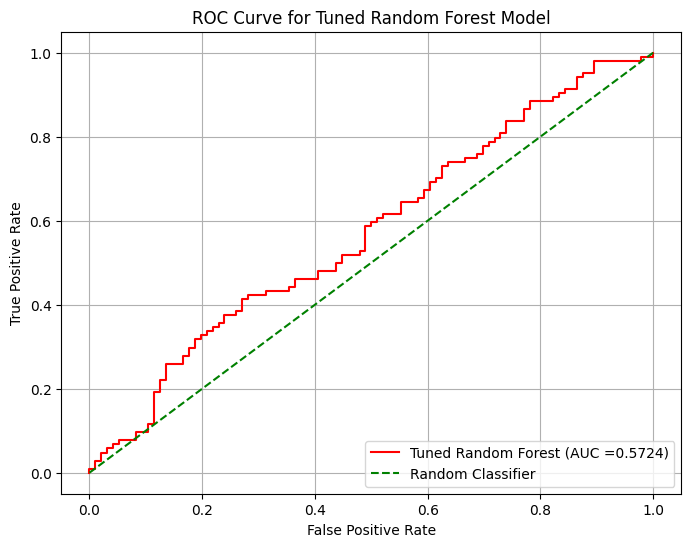

In [528]:
#ROC curve values
fpr, tpr,_= roc_curve(Y_test, Y_pred_proba_tuned_rf)

#ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Tuned Random Forest (AUC ={roc_auc_tuned_rf:.4f})', color='red')
plt.plot([0, 1], [0, 1], '--', label='Random Classifier', color='green')
plt.title('ROC Curve for Tuned Random Forest Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

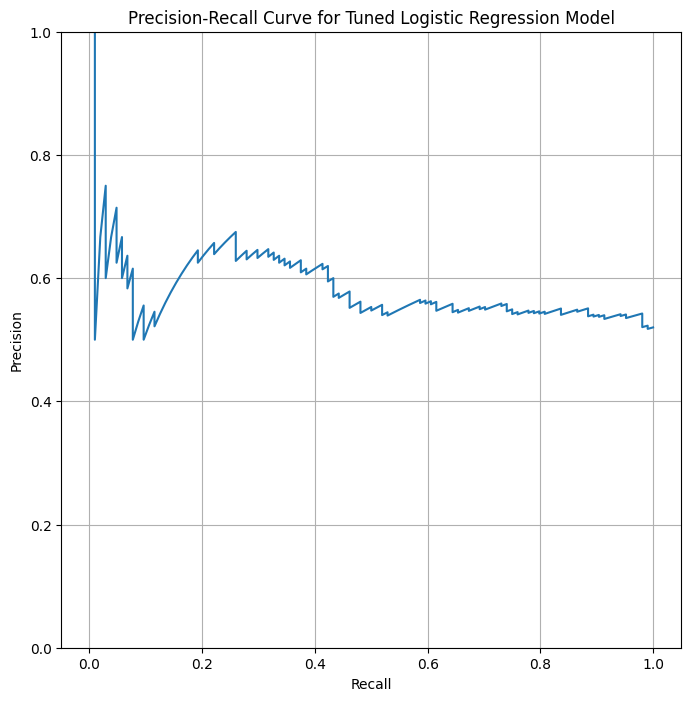

In [529]:
#precision-recall curve
precision, recall, _ = precision_recall_curve(Y_test, Y_pred_proba_tuned_rf)

#average precision score
plt.figure(figsize=(8, 8))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Tuned Logistic Regression Model')
plt.grid()
plt.ylim(0, 1)
plt.show()

[[49 47]
 [47 57]]


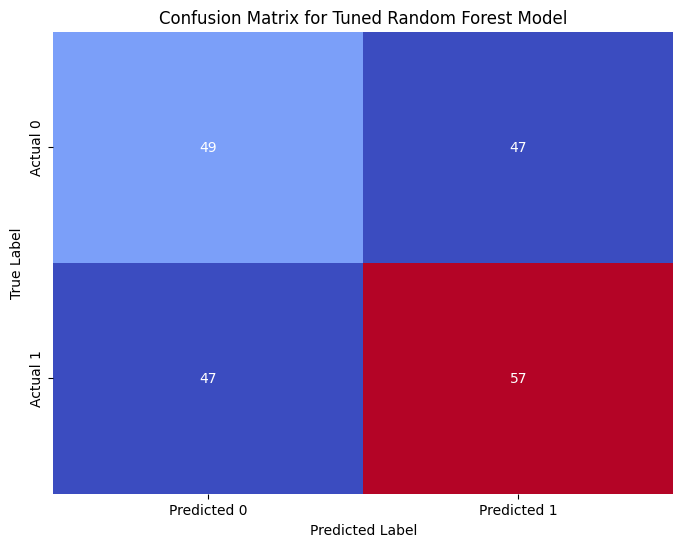

In [530]:
#confusion matrix
cm=confusion_matrix(Y_test, Y_pred_tuned_rf)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Tuned Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**3.XGBoost Model**

In [531]:
xgb_model = XGBClassifier(random_state=40)

xgb_model.fit(X_train_scaled, Y_train)

Y_pred_xgb = xgb_model.predict(X_test_scaled)
print("working")

working


In [532]:
xgb_accuracy = accuracy_score(Y_test, Y_pred_xgb)

print(f"Accuracy Score: {xgb_accuracy:.4f}")


Accuracy Score: 0.5150


In [533]:
correct_predictions= (Y_pred_xgb == Y_test).sum()
incorrect_predictions = (Y_pred_xgb != Y_test).sum()
print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")

Correct Predictions: 103
Incorrect Predictions: 97


In [534]:
class_report = classification_report(Y_test, Y_pred_xgb)
print("Classification Report:\n\n", class_report)

Classification Report:

               precision    recall  f1-score   support

           0       0.50      0.56      0.53        96
           1       0.54      0.47      0.50       104

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.52      0.52      0.51       200



In [535]:
cross_val_score= cross_val_score(xgb_model, X, Y, cv=5)

print("Cross-validation scores:", cross_val_score)
print(f"Mean cross-validation accuracy: {cross_val_score.mean():.4f}")

Cross-validation scores: [0.56       0.51256281 0.4120603  0.45728643 0.51758794]
Mean cross-validation accuracy: 0.4919


In [543]:
#defining parameters
param_grid ={
    'n_estimators': [100, 200, 300],
    'max_depth': [1,2,3,4,5]
}

xgb=XGBClassifier(random_state=40)

grid_search=GridSearchCV(estimator=xgb,
                         param_grid=param_grid,
                         cv=5,
                         scoring='accuracy',
                         n_jobs=-1,
                         verbose=2)
grid_search.fit(X_train_scaled, Y_train)
print('Fitted')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitted


In [545]:
print("best parameters: " + str(grid_search.best_params_))

best parameters: {'max_depth': 1, 'n_estimators': 200}


In [546]:
#XGBoost-hyperparameter tuning
tuned_xgb=XGBClassifier(max_depth= 1, n_estimators= 200, random_state=40)
tuned_xgb.fit(X_train_scaled, Y_train)
Y_pred_tuned_xgb = tuned_xgb.predict(X_test_scaled)
tuned_xgb_accuracy = accuracy_score(Y_test, Y_pred_tuned_xgb)
tuned_xgb_classification_report = classification_report(Y_test, Y_pred_tuned_xgb)

print(f"Accuracy Score: {tuned_xgb_accuracy:.4f}")
print(f"Classification Report:\n {tuned_xgb_classification_report}")

Accuracy Score: 0.5650
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.49      0.52        96
           1       0.57      0.63      0.60       104

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200



In [549]:
Y_pred_proba_tuned_xgb= tuned_xgb.predict_proba(X_test_scaled)[:, 1]

#roc-auc score
roc_auc_tuned_xgb = roc_auc_score(Y_test, Y_pred_proba_tuned_xgb)
print(f"Tuned Model ROC AUC Score: {roc_auc_tuned_xgb:.4f}")

Tuned Model ROC AUC Score: 0.5853


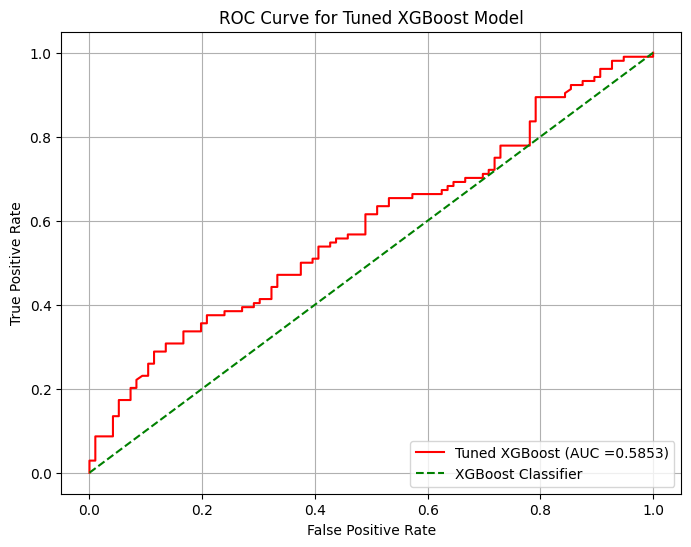

In [550]:
#roc curve values
fpr, tpr,_= roc_curve(Y_test, Y_pred_proba_tuned_xgb)

#roc curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Tuned XGBoost (AUC ={roc_auc_tuned_xgb:.4f})', color='red')
plt.plot([0, 1], [0, 1], '--', label='XGBoost Classifier', color='green')
plt.title('ROC Curve for Tuned XGBoost Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

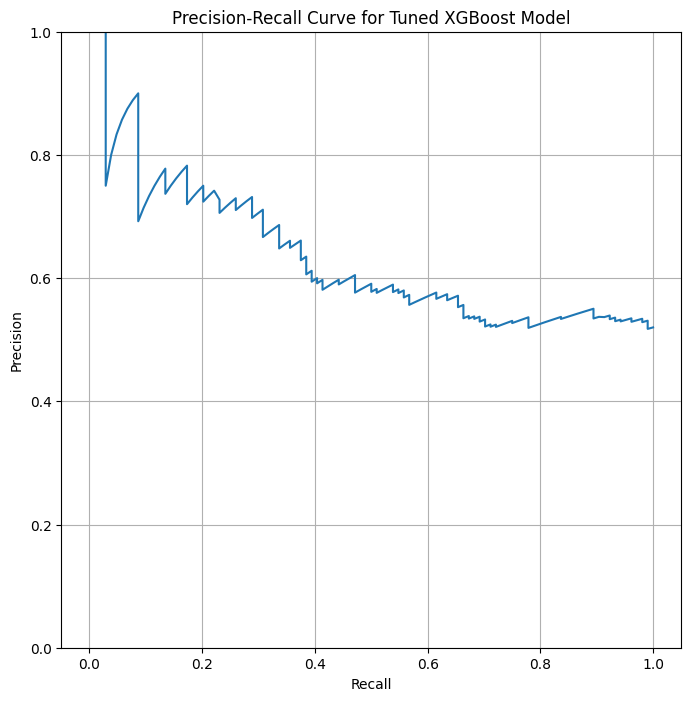

In [555]:
#precision-recall curve
precision, recall, _ = precision_recall_curve(Y_test, Y_pred_proba_tuned_xgb)

#average precision score
plt.figure(figsize=(8, 8))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Tuned XGBoost Model')
plt.grid()
plt.ylim(0, 1)
plt.show()

[[47 49]
 [38 66]]


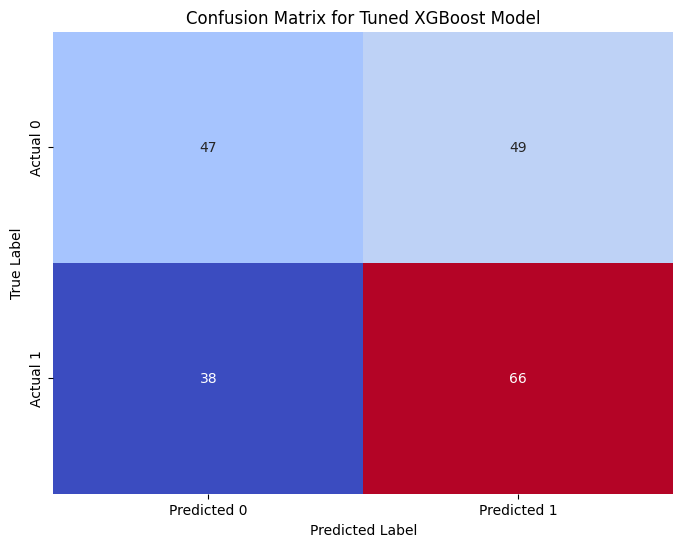

In [556]:
#confusion matrix
cm=confusion_matrix(Y_test, Y_pred_tuned_xgb)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Tuned XGBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Model Comparison**